# Initial analysis on a dataset of UCI Machine Learning Repository

In this jupyter notebook, I will show a initial data analysis for [Adult Data Set](http://archive.ics.uci.edu/ml/datasets/Adult) from UCI Machine Learning Repository. The goal of this dataset is to *predict whether income exceeds $50K/yr based on census data like age, gender, education and etc*. I will first use Exploratory Data Analysis to understand this dataset and build a suitable classifier based on some experience.

## Acquire data

In [1]:
import os
import requests

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/"
filename = ['adult.data', 'adult.names', 'adult.test']
urls = ['%s%s' % (url, f) for f in filename]

data_dir = 'data'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

for u in urls:
    response = requests.get(u)
    name = os.path.basename(u)
    with open(os.path.join(data_dir, name), 'wb') as f:
        f.write(response.content)

## Exploration of data
The very first step is to understand what data do we have, from the attribute information of this dataset, we can know that we got 15 columns, let's import pandas and start exploring!

In [2]:
import pandas as pd

colname = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
data = pd.read_csv('data/adult.data', names=colname, na_values=" ?")
print('We have %d rows and %d columns' % (data.shape[0], data.shape[1]))
data.head()

We have 32561 rows and 15 columns


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Variable Identification

In [3]:
categorical_var = [column for column in data.columns if data[column].dtype == 'object']
conti_var = [column for column in data.columns if column not in categorical_var]
print('We have %d categorical variables which are: \n%s' % (len(categorical_var), categorical_var))
print('and %d continuous variables which are: \n%s' % (len(conti_var), conti_var))

We have 9 categorical variables which are: 
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']
and 6 continuous variables which are: 
['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [4]:
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


There are 9 categorical variables and 6 continuous variables in this dataset, note that *fnlwgt* actually means final sampling weight, which would not help in classifier, so we can just delete this column.

In [5]:
conti_var.pop(conti_var.index('fnlwgt'))
data.drop('fnlwgt', axis=1, inplace=True)

### Univariate Analysis
We always understand our dataset by plotting it's distribution and histogram is the always the first plot that gets into my mind.

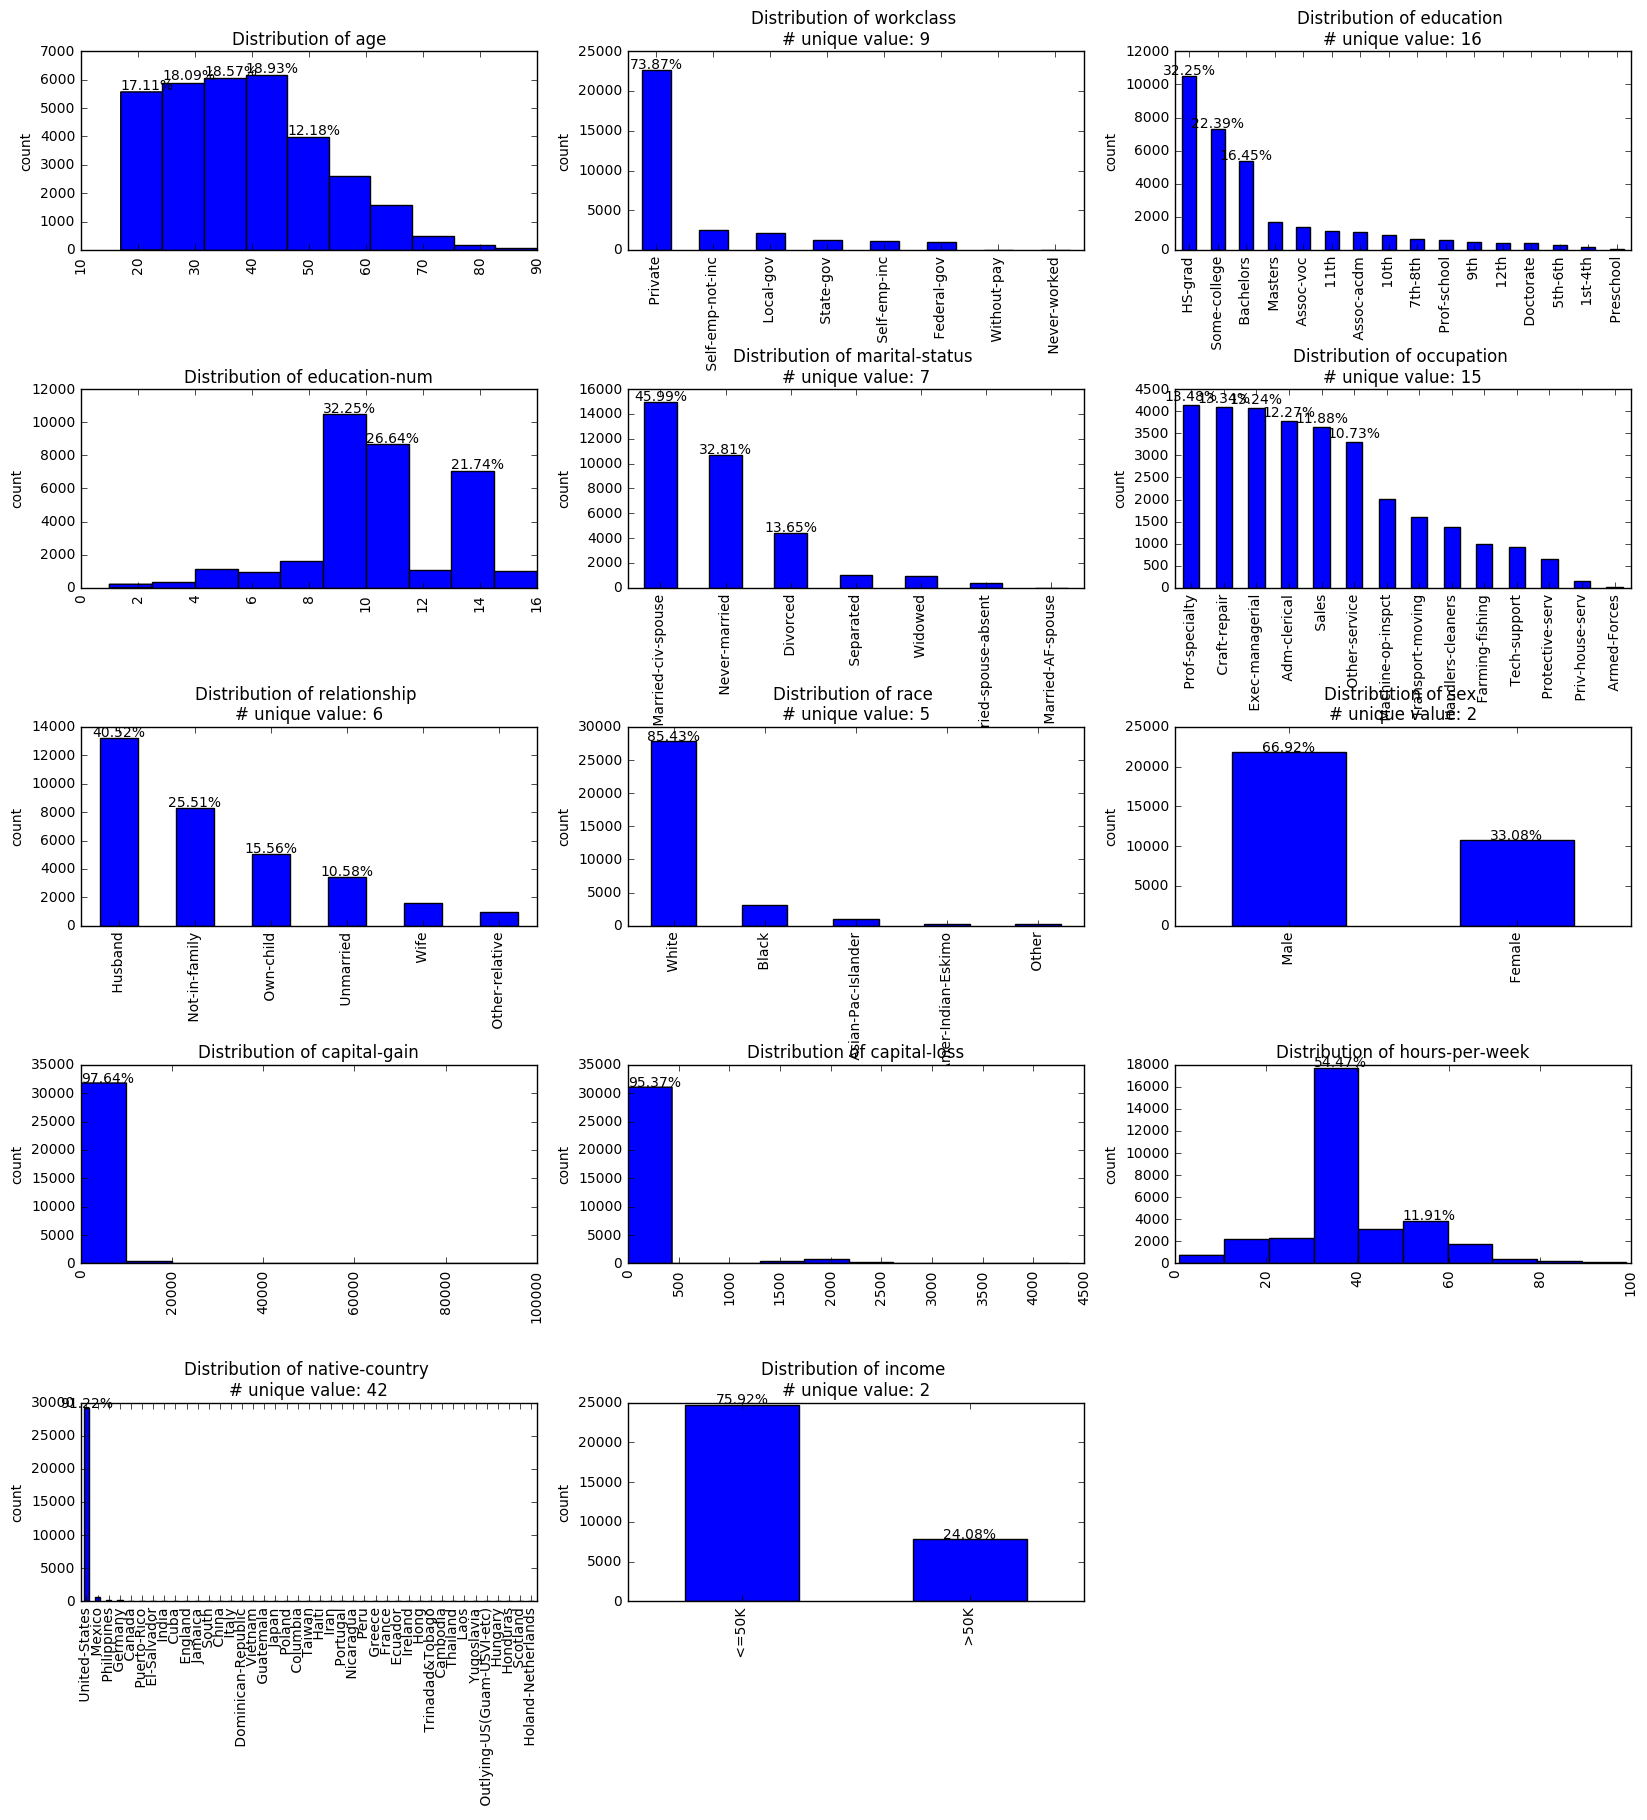

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,20))
cols = 3
rows = int(float(data.shape[1]) / cols) + 1
for i, column in enumerate(data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    
    if data[column].dtype == 'object':
        ax.set_title('Distribution of %s \n# unique value: %d' % (column, len(data[column].unique())))
        ax.set_ylabel('count')
        v = data[column].value_counts()
        v.plot(kind="bar", axes=ax)
        # label percentage text for concerned bins
        for i, v_temp in enumerate(v):
            percent = round(v_temp * 100 / sum(v), 2)
            # only show the label if the percent is bigger than 10%
            if percent > 10:
                ax.text(i, v_temp + 100, "{}%".format(percent), ha = 'center')
    else:
        ax.set_title('Distribution of %s' % column)
        ax.set_ylabel('count')
        v = data[column]
        counts, bins, patches = ax.hist(v)
        # label percentage text for concerned bins
        for i, c in enumerate(counts):
            percent = round(c * 100 / sum(counts), 2)
            # only show the label if the percent is bigger than 10%
            if percent > 10:
                ax.text(bins[i], c + 100, "{}%".format(percent))
        
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

From the plot above, we can quickly observe that: 
* our data is populated mainly by USA white male people. 
* the classes to be predicted, which is income, is imbalanced (3:1).

### Bivariate Analysis
We always want to understand our data not only in one dimension.

#### For continuous variables

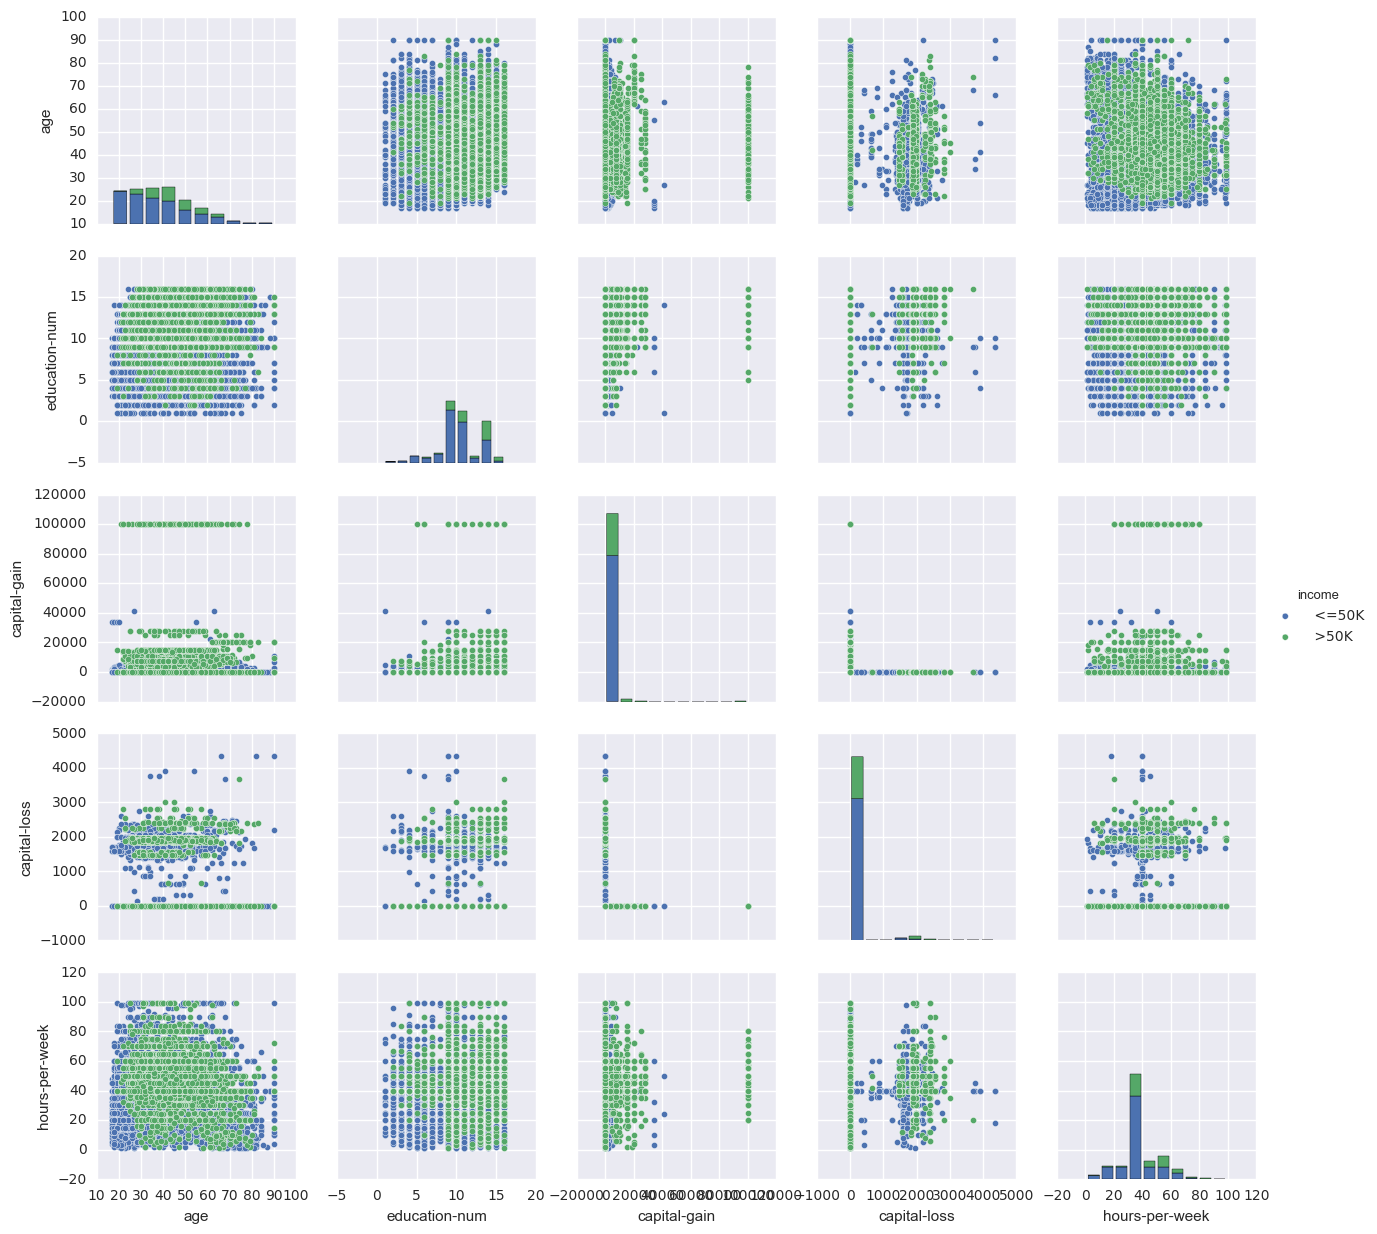

In [7]:
import seaborn as sns
sns.pairplot(data, hue='income')

We can roughly see that people with higher income have large education-num, even if they have smaller education-num, they have relatively shorter working hours-per-week. For other variables, it's really hard to tell, but still we have more sense about this dataset.

#### For categorical variables

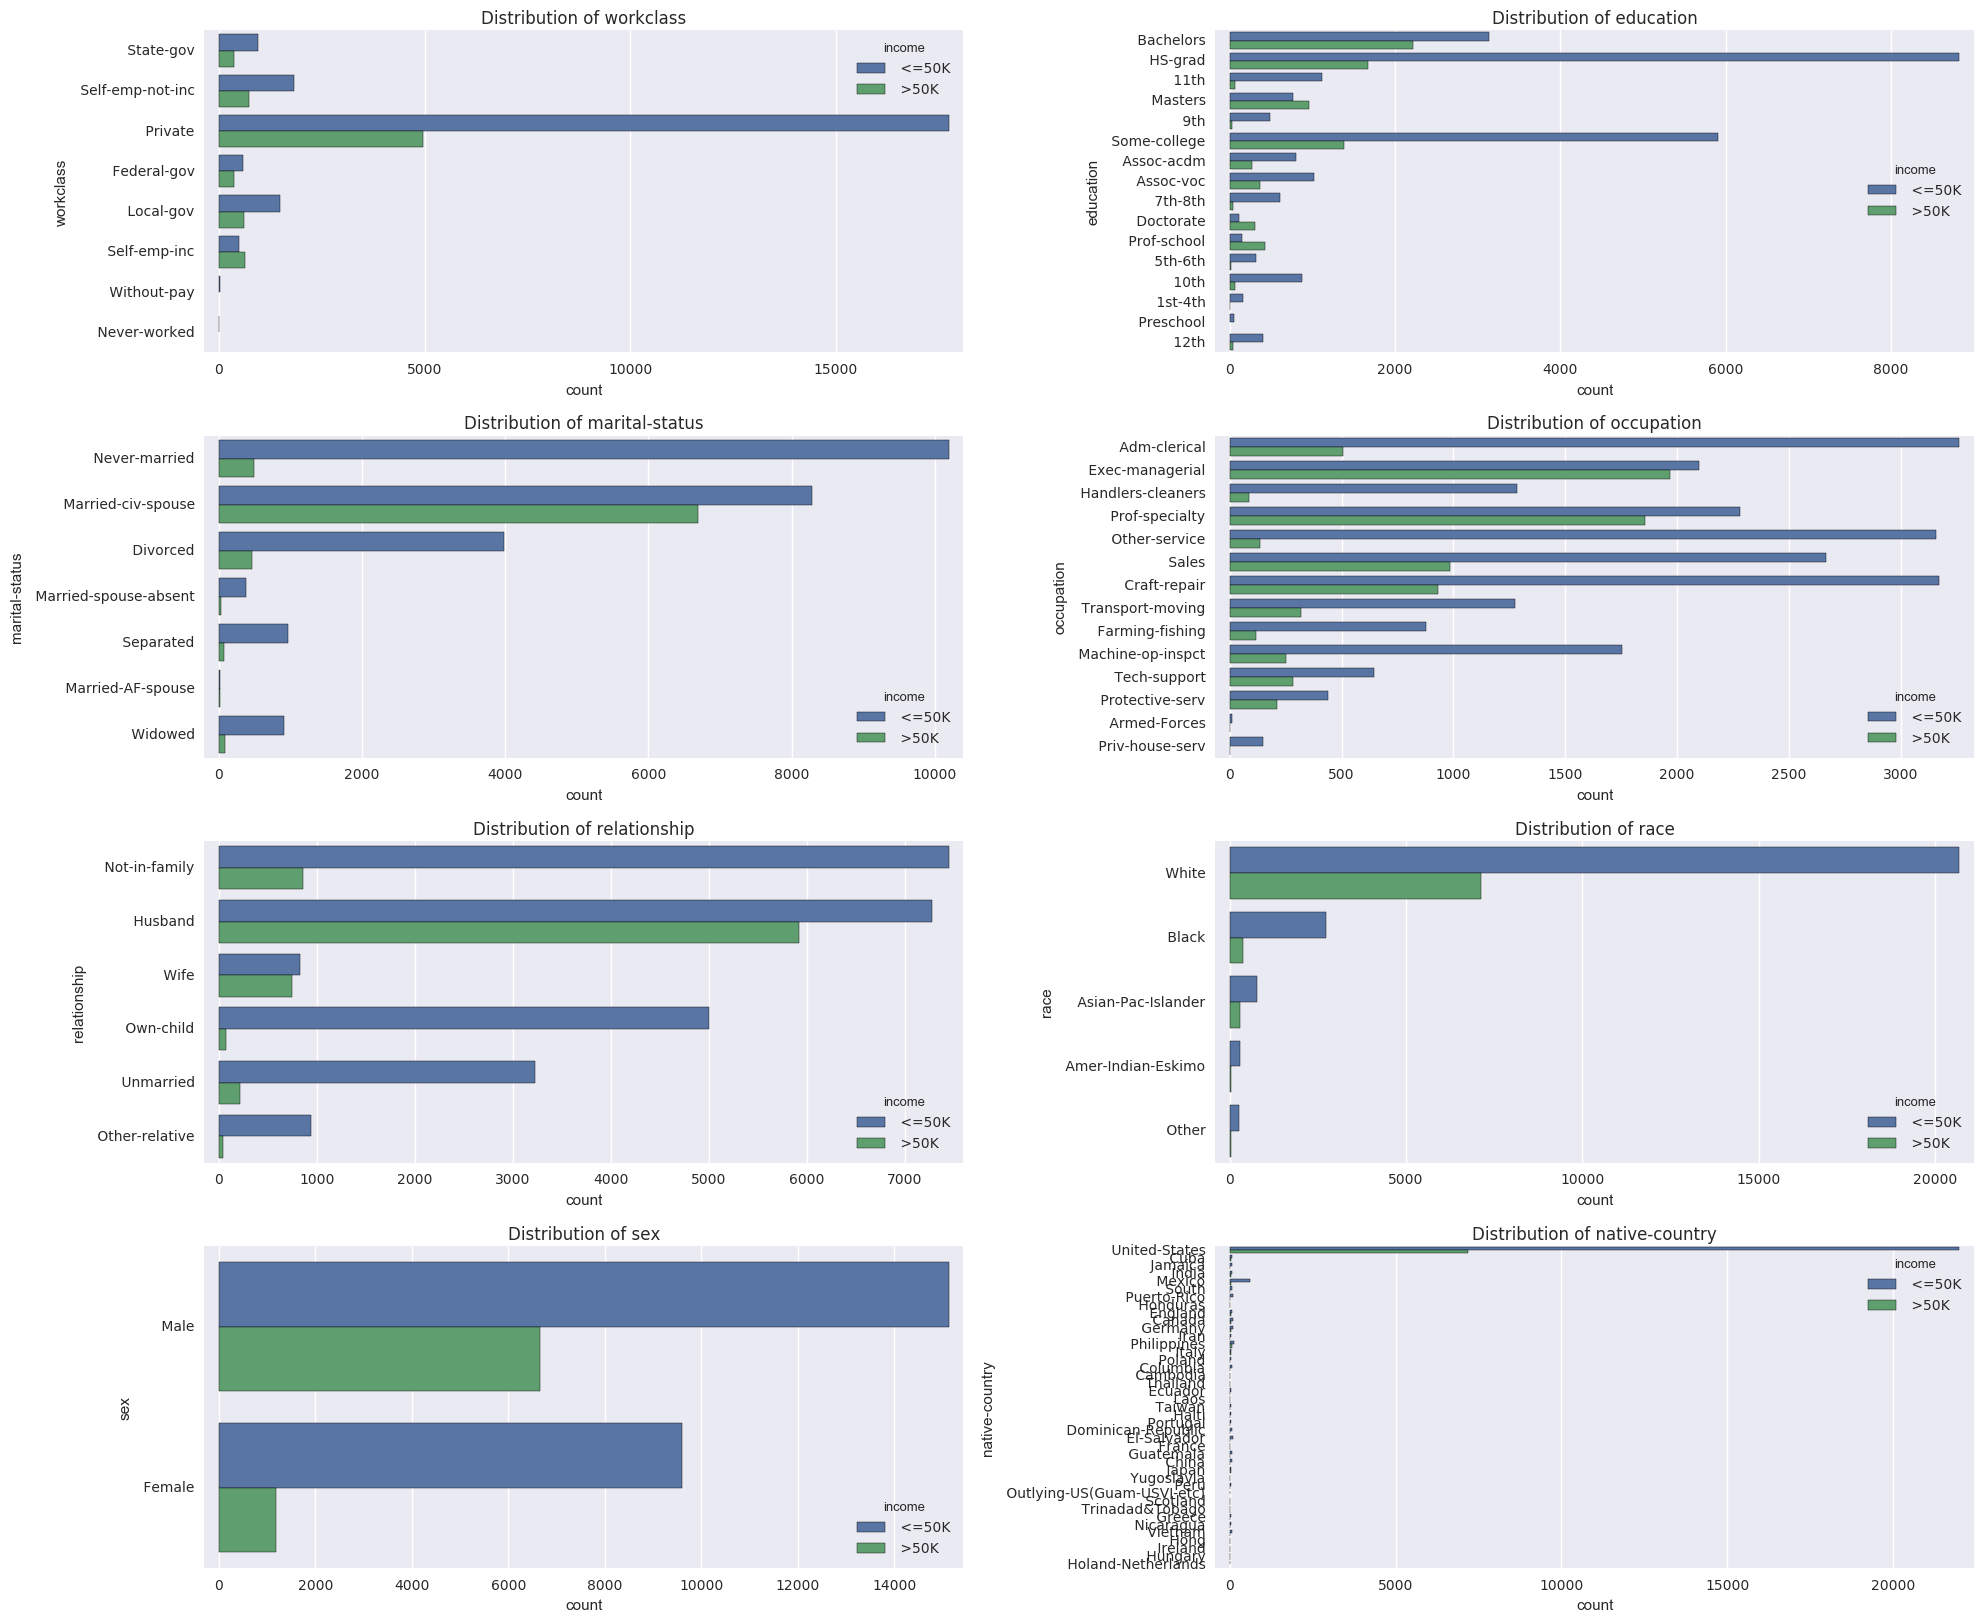

In [8]:
fig = plt.figure(figsize=(20,20))
cols = 2
rows = int(float(len(categorical_var)) / cols) + 1
for i, column in enumerate(categorical_var):
    if column == 'income':
        break
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.margins(0.02)
    ax.set_title('Distribution of %s' % column)
    sns.countplot(y=column, hue='income', data=data)
plt.tight_layout()

By adding the 'income' dimension into histogram plot, we can observed that distribution 
#### Normalized distribution

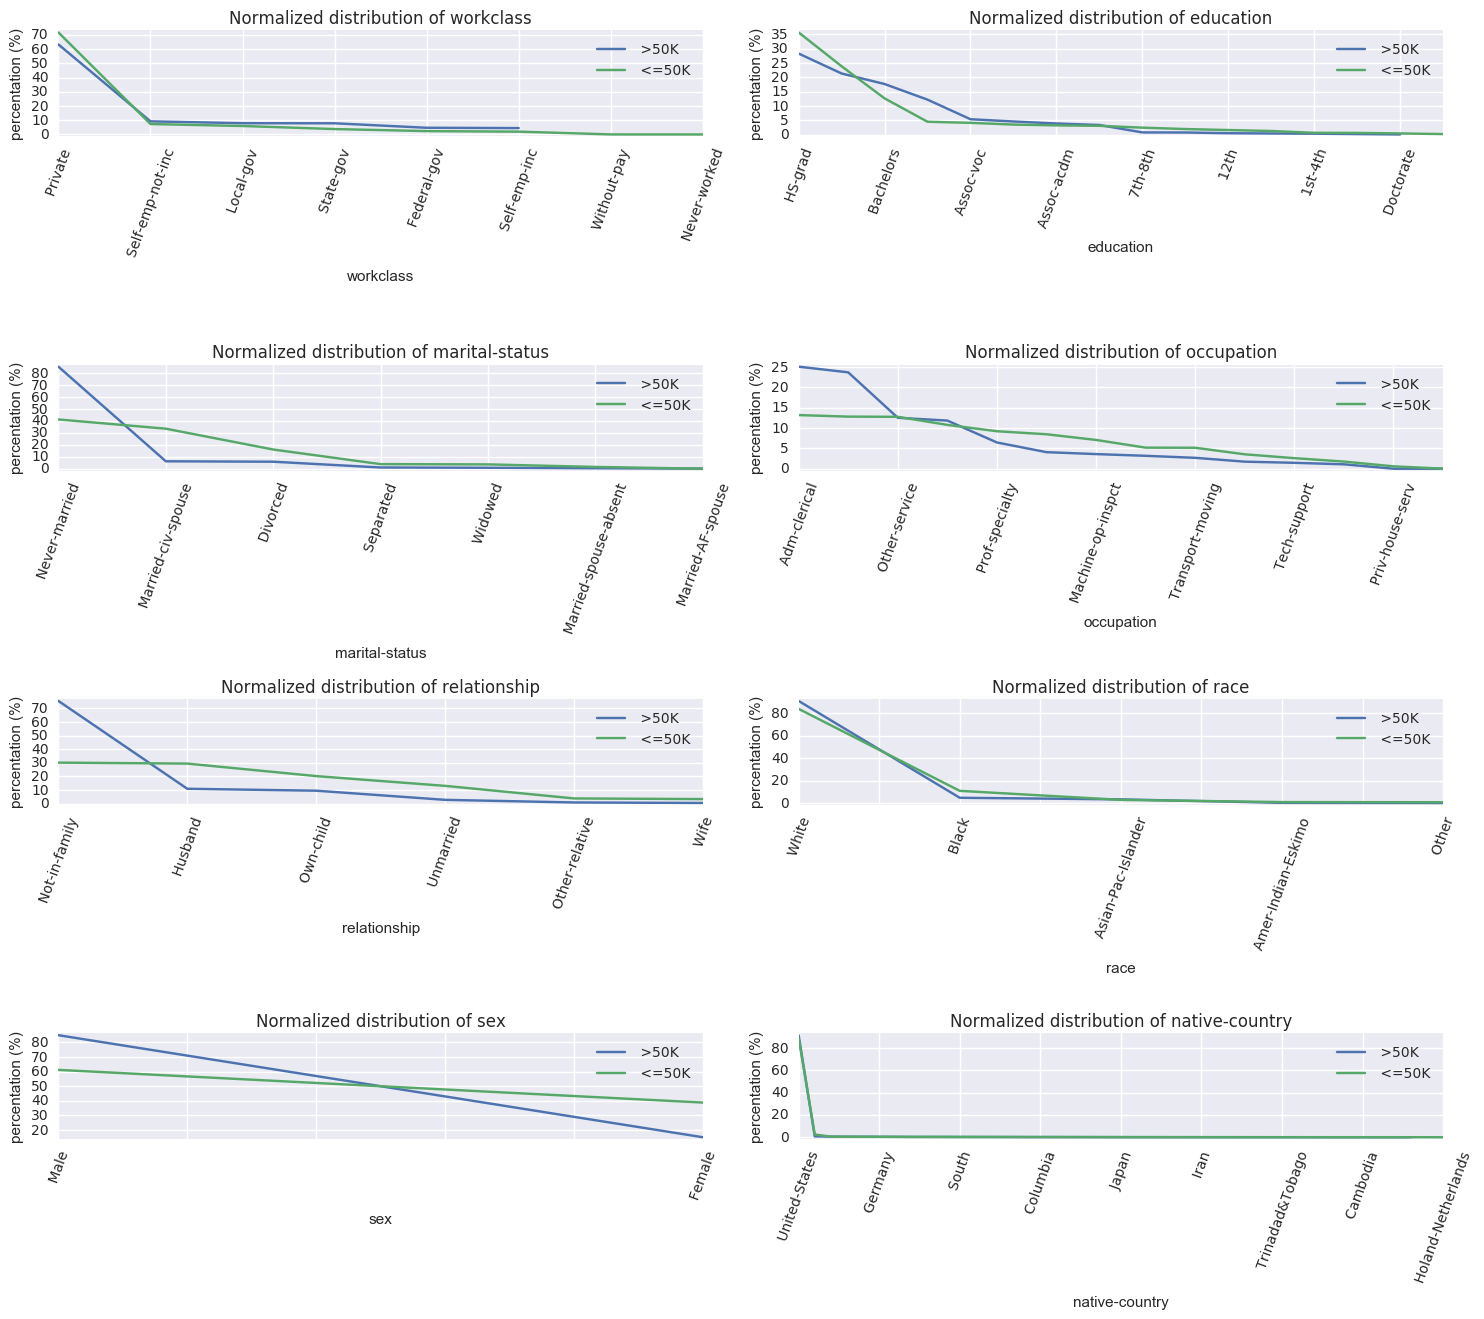

In [9]:
fig = plt.figure(figsize=(15,15))
cols = 2
rows = int(float(len(categorical_var)) / cols) + 1
for i, column in enumerate(categorical_var):
    if column == 'income':
        break
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title('Normalized distribution of %s' % column)
    ax.margins(0.02)
    v_counts = data.groupby('income')[column].value_counts()
    v_counts_total = data.groupby('income').education.value_counts().groupby(level='income').agg(sum)
    groups = (v_counts / v_counts_total) * 100
    groups[' >50K'].plot(axes=ax, label=' >50K')
    groups[' <=50K'].plot(axes=ax, label=' <=50K')
    plt.xticks(rotation=70)
    ax.set_ylabel('percentation (%)')
    ax.legend()
plt.tight_layout()

By this normalization, now we can easily observe the difference of distribution for each bins of our categorical variables. For instance, there are obvious difference between different group inside sex and occupation variables.

### Missing Value Imputation
It is always good to check for the missing values before we start building the model.

In [10]:
data.isnull().sum()

age                  0
workclass         1836
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

Seems like we have 3 categorical variables that have missing values.

In [11]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == 'object' else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [12]:
data_imp = DataFrameImputer().fit_transform(data)

In [13]:
data_imp.loc[data.workclass.isnull()].head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
27,54,Private,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
61,32,Private,7th-8th,4,Married-spouse-absent,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States,<=50K
69,25,Private,Some-college,10,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50K
77,67,Private,10th,6,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,2,United-States,<=50K
106,17,Private,10th,6,Never-married,Prof-specialty,Own-child,White,Female,34095,0,32,United-States,<=50K


In [14]:
data_imp.loc[data.occupation.isnull()].head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
27,54,Private,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
61,32,Private,7th-8th,4,Married-spouse-absent,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States,<=50K
69,25,Private,Some-college,10,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50K
77,67,Private,10th,6,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,2,United-States,<=50K
106,17,Private,10th,6,Never-married,Prof-specialty,Own-child,White,Female,34095,0,32,United-States,<=50K


In [15]:
data_imp.loc[data['native-country'].isnull()].head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14,40,Private,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>50K
38,31,Private,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,United-States,>50K
51,18,Private,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,30,United-States,<=50K
61,32,Private,7th-8th,4,Married-spouse-absent,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States,<=50K
93,30,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,1573,35,United-States,<=50K


We got three categorical variables which are workclass, occupation and native-country have missing values. For simplicity, we replace them by the most frequent value respectively. Otherwise, we could replace them by some prior information of other columns.

### Label Encoding
Since we have categorical variables in our dataset and scikit-learn (the library I will use to build model) does not accept non-numerical features, I will do a preprocessing to create dummy variables.

In [16]:
data_dummy = pd.get_dummies(data_imp, drop_first=True)

In [17]:
data_dummy.columns

Index(['age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_ Local-gov', 'workclass_ Never-worked',
       'workclass_ Private', 'workclass_ Self-emp-inc',
       'workclass_ Self-emp-not-inc', 'workclass_ State-gov',
       'workclass_ Without-pay', 'education_ 11th', 'education_ 12th',
       'education_ 1st-4th', 'education_ 5th-6th', 'education_ 7th-8th',
       'education_ 9th', 'education_ Assoc-acdm', 'education_ Assoc-voc',
       'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad',
       'education_ Masters', 'education_ Preschool', 'education_ Prof-school',
       'education_ Some-college', 'marital-status_ Married-AF-spouse',
       'marital-status_ Married-civ-spouse',
       'marital-status_ Married-spouse-absent',
       'marital-status_ Never-married', 'marital-status_ Separated',
       'marital-status_ Widowed', 'occupation_ Armed-Forces',
       'occupation_ Craft-repair', 'occupation_ Exec-managerial',
       '

### Variable Creation
Just before we really start building model, notice that there we actually can create some features with the current variables. In this case, I create a new feature *capital-net* by *capital-gain* and *capital-loss*.

In [18]:
data_dummy['capital-net'] = data_dummy['capital-gain'] - data_dummy['capital-loss']

## Building Classifier
Okay, now we can talk about building a classifier. In my opinion, there are so many algorithms to build a model nowaday, we can't really decide which classifier we want to apply at last until we do some experiments. In the following section, I will use logistic regression, and XGBoost to build models and valid which of these algorithm will perform better in this dataset.

In [19]:
X, y = data_dummy.drop('income_ >50K', axis=1).values, data_dummy['income_ >50K'].values

### Variable Transformation
Normally, a model can improve if the variables are scaled, we can do some experiments later, let's create a data with scaled variables for continuous variables.

In [20]:
from sklearn.preprocessing import scale
X_scaled = X.copy()
X_scaled[:, :5] = scale(X_scaled[:, :5])

### Preparation for Cross-Validation
Also, I want to be certain about the model's ability to generalize to unseen data, I split the dataset into training set and validation set before building model.

In [21]:
from sklearn.model_selection import train_test_split

### Training Classifier


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import time

def train_model(X, y, model_type):
    if model_type == "lgr":
        model = LogisticRegression()
    elif model_type == 'xgb':
        model = XGBClassifier(max_depth=5, gamma=0.5)
    model.fit(X, y)
    return model
def score(X_train, X_test, y_train, y_test, model):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    acc_train = accuracy_score(y_train, pred_train)
    acc_test = accuracy_score(y_test, pred_test)
    
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    
    return acc_train, acc_test, f1_train, f1_test

In [23]:
print('Start training model')
start = time.clock()
results = pd.DataFrame()
best_model = {'lgr': {'model': None, 'f1': 0}, 
              'xgb': {'model': None, 'f1': 0}}
for i in range(10):
    seed = np.random.randint(0, 1000)
    # set random_state for fairly comparation between scaled and unscaled training data
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train_scaled, X_valid_scaled, y_train_scaled, y_valid_scaled = train_test_split(X_scaled, y, test_size=0.2, random_state=seed)
    
    for m_type in ['lgr', 'xgb']:
        print('%s round %s' % (i+1, m_type))
        model = train_model(X_train, y_train, m_type)
        model_sc = train_model(X_train_scaled, y_train_scaled, m_type)
        acc_train, acc_valid, f1_train, f1_valid = score(X_train, X_valid, y_train, y_valid, model)
        acc_train_sc, acc_valid_sc, f1_train_sc, f1_valid_sc = score(X_train_scaled, X_valid_scaled, y_train_scaled, y_valid_scaled, model_sc)
        
        res_temp = {'model_type': [m_type]*4, 
            'type': ['training', 'validation']*2, 
            'is_scaled': ['unscaled'] * 2 + ['scaled'] * 2,
            'acc': [acc_train, acc_valid, acc_train_sc, acc_valid_sc], 
            'f1': [f1_train, f1_valid, f1_train_sc, f1_valid_sc]}
        results = results.append(pd.DataFrame(res_temp))
        if f1_valid > best_model[m_type]['f1']:
            print('Current best model, f1: %s' % f1_valid)
            best_model[m_type]['f1'] = f1_valid
            best_model[m_type]['model'] = model
print('Done! Training all model took %s secs' % round(time.clock() - start, 3))

Start training model
1 round lgr
Current best model, f1: 0.64596716631
1 round xgb
Current best model, f1: 0.712871287129
2 round lgr
2 round xgb
3 round lgr
3 round xgb
4 round lgr
Current best model, f1: 0.650821391122
4 round xgb
5 round lgr
Current best model, f1: 0.652398523985
5 round xgb
6 round lgr
Current best model, f1: 0.661971830986
6 round xgb
7 round lgr
7 round xgb
8 round lgr
8 round xgb
9 round lgr
9 round xgb
10 round lgr
10 round xgb
Done! Training all model took 113.129 secs


### Visualization of results

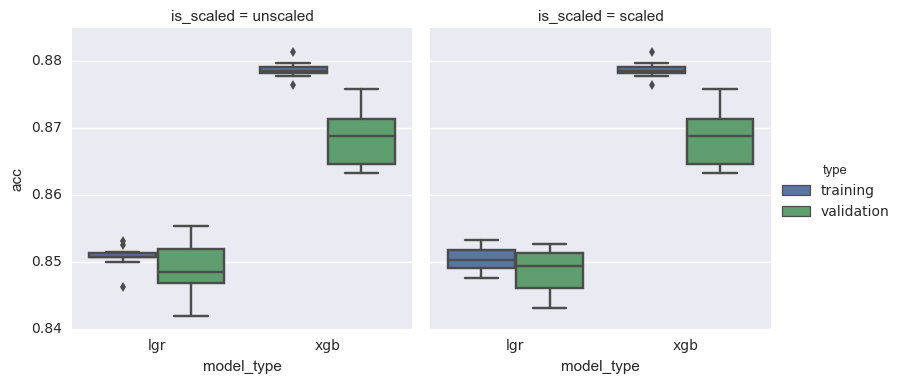

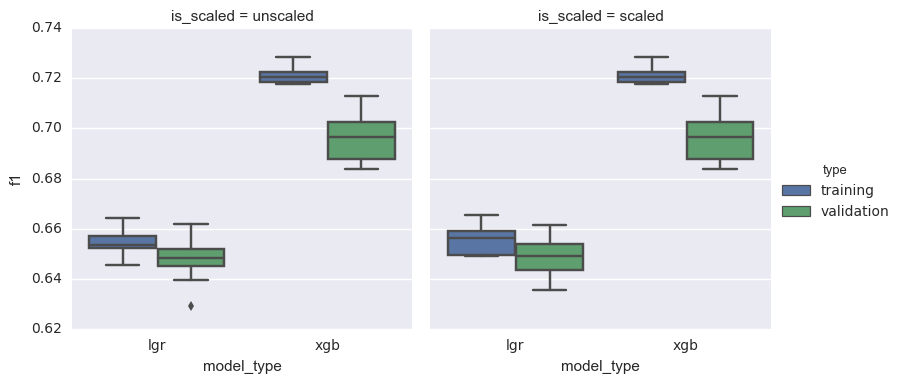

In [24]:
for i, score in enumerate(['acc', 'f1']):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.set_title('Distribution of %s for sampling 10 times' % score)
    sns.factorplot('model_type', hue='type', y=score, col='is_scaled', data=results, kind='box')

From the plot above, xgboost outperformed logistic regression very well expecially in F1-score. Note that F1-score is the harmonic mean of precision and recall, where precision is how many people that our model predict income is >50K is really income >50K, recall is how many people that is really income that our model had predicted correctly.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/525px-Precisionrecall.svg.png">
A very well graph to understand precision and recall.

### Interpretation
It's cleary that XGBoost beat off logistic regression. Let's campare what has this model learn and compare with a basic correlation analysis.

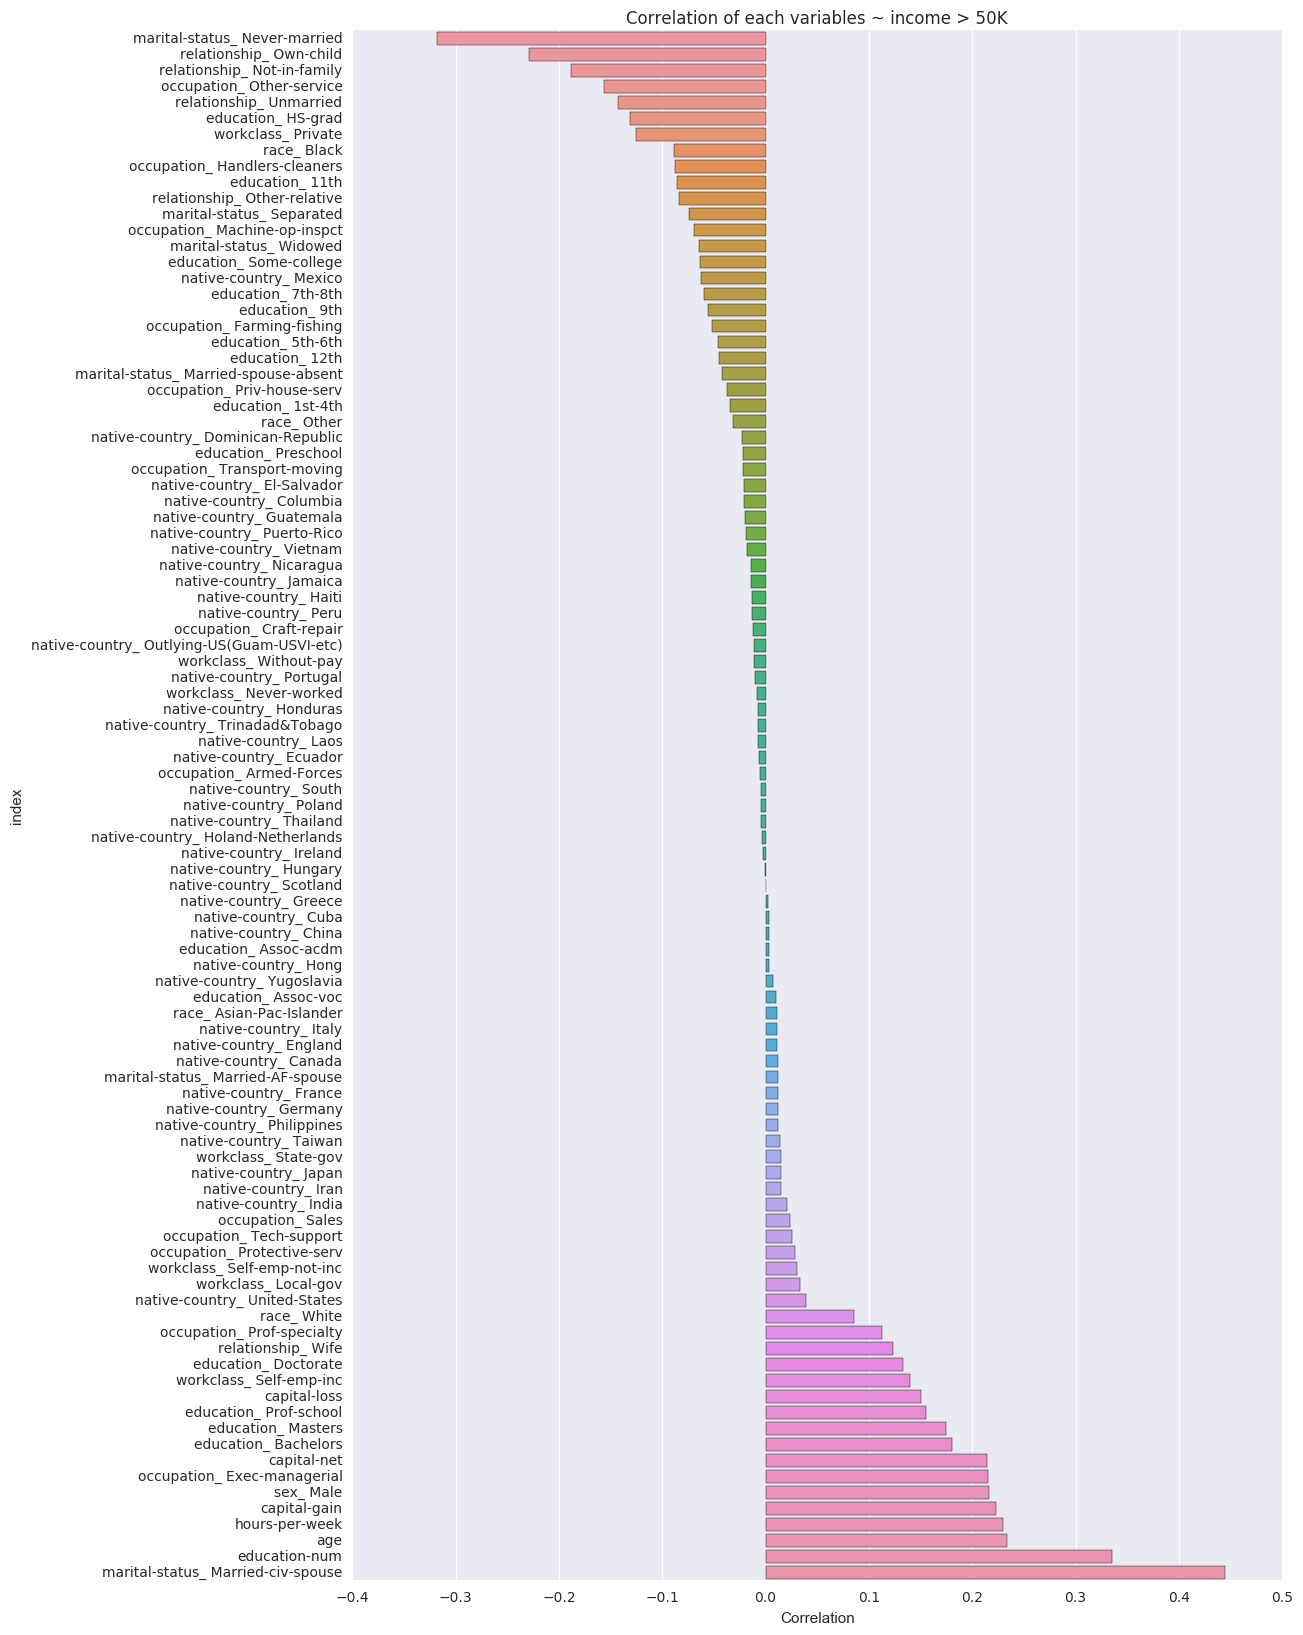

In [25]:
correlation = data_dummy.corr().sort_values(by='income_ >50K')
correlation = correlation.drop('income_ >50K').reset_index()
plt.figure(figsize=(12, 20))
plt.title('Correlation of each variables ~ income > 50K')
sns.barplot(y='index', x='income_ >50K', data=correlation)
plt.xlabel('Correlation')

Although we have many dummy variables in this dataset, still I have draw a correlation plot comparing income among other variables. There are some findings:
* people that married tend to have higher income
* people that are well-educated tend to have higher income
* older people tend to have higher income
* people that never married tend to have lower income
* people that owned children tend to have lower income

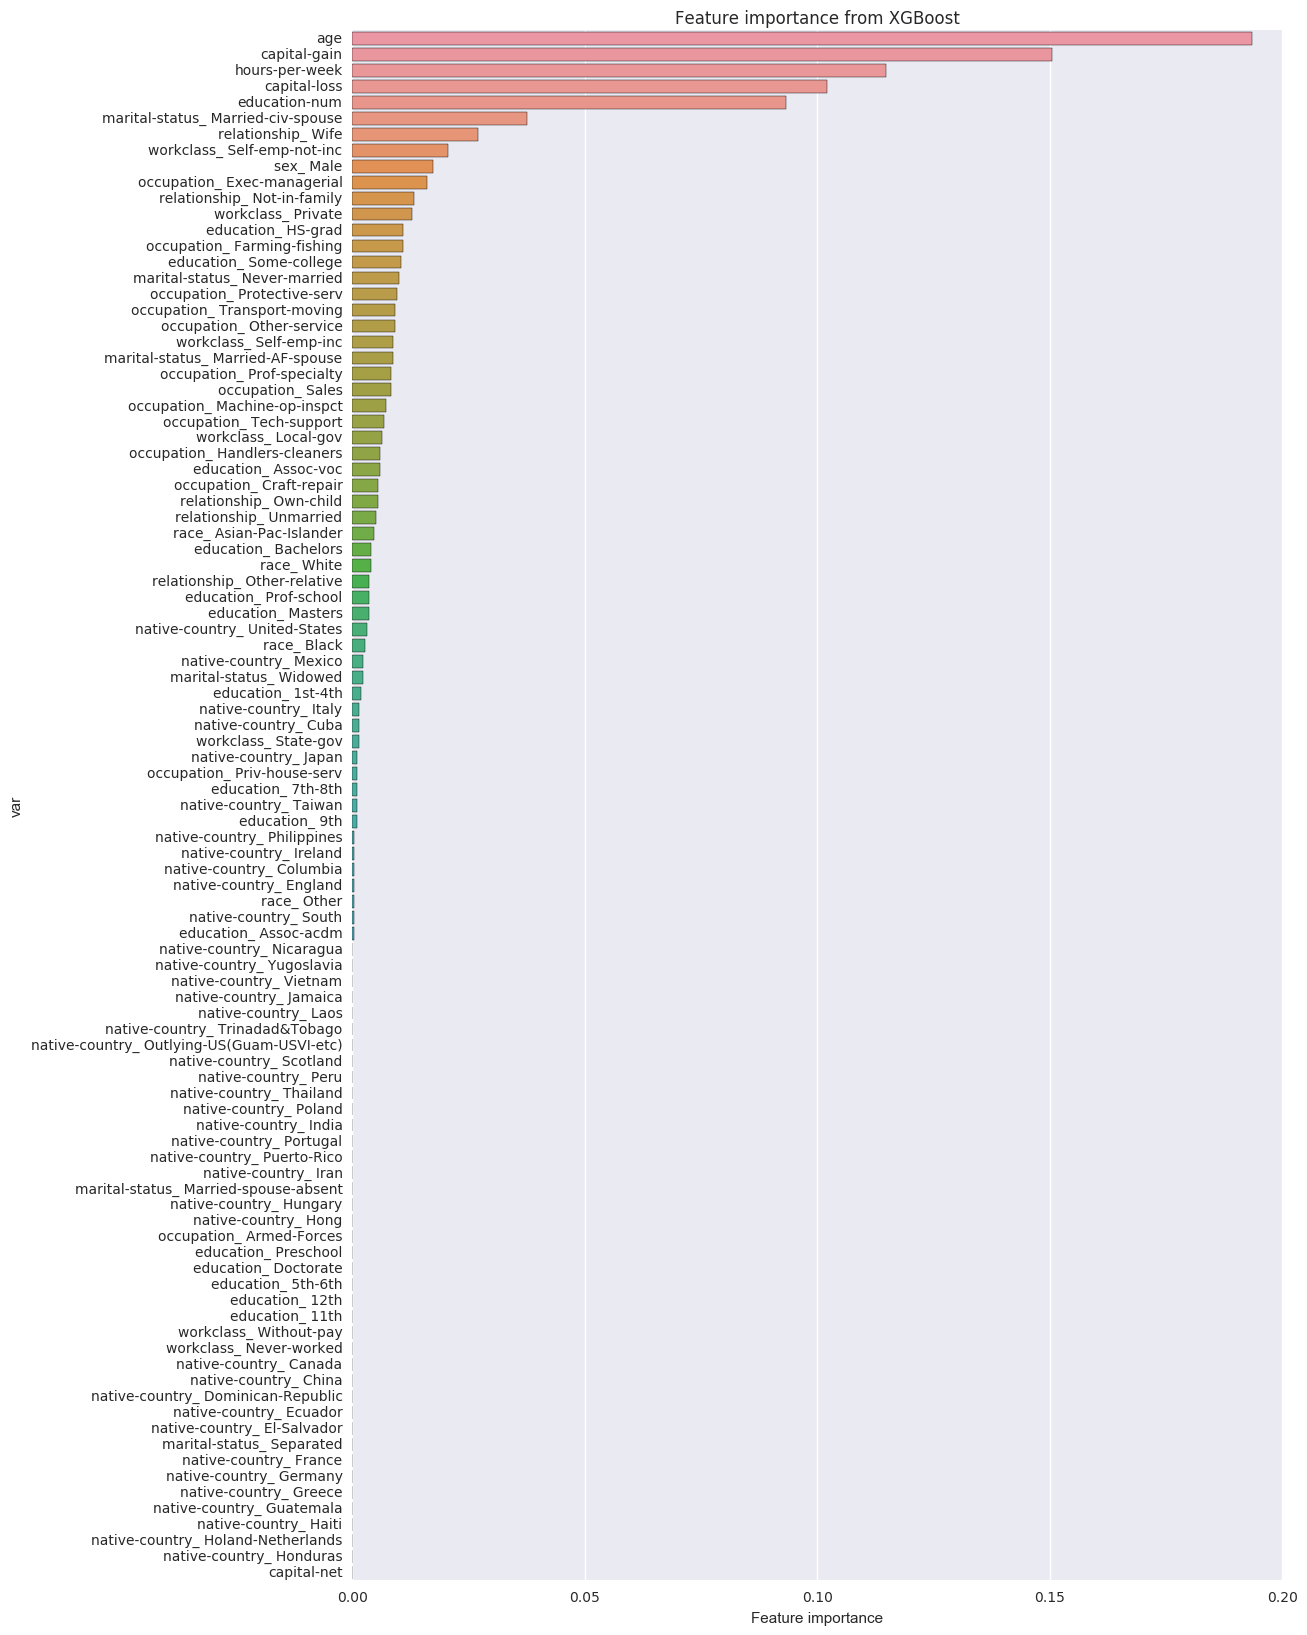

In [27]:
best_xgb = best_model['xgb']['model']
f_imp = pd.DataFrame({'var': data_dummy.drop('income_ >50K', axis=1).columns, 'feature-importance': best_xgb.feature_importances_})
f_imp.sort_values(by='feature-importance', inplace=True, ascending=False)
plt.figure(figsize=(12, 20))
plt.title('Feature importance from XGBoost')
sns.barplot(y='var', x='feature-importance', data=f_imp)
plt.xlabel('Feature importance')

Feature importance of XGBoost provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance. From the feature importance plot above, we can observe that:
* older people tend to have higher income, which has same result as correlation
* people that invest tend to have higher income
* people that worked harder tend to have higher income
* again, people that are well-educated tend to have higher income

### Room for improvement and some experience
For some applications, a accuracy of 88% and F1 of 0.71 are quite enough information to make next move, but still, there are lots of thing that can improve this model, for example:
* hyperparameter tuning
    * I only sample 10 times for cross-validation with same hyperparameter, in fact, there are a lots of param like max-depth, gamma that can be tuned for a good XGBoost model
* feature selection
    * Scikit-learn provides a SelectFromModel class that takes a model and can transform a dataset into a subset with selected features. With some effort, we can evaluate the model by starting with all features and ending with a subset with the most important feature to find the best model.
    
You might think all the findings above is nonsense, you call tell me all the findings above just followed by intuition or common sense. Yes, but that might be the reason we call 'data mining'. We analyze data like a miner, excavate off wastes, but no getting gold mines every time. I truly believe that a good company requires more data insight instead of only intuition and experience of decision makers, and a decent data visualization is worth a thousand words.